In [1]:
#!echo 'CERO0cero' | sudo -S apt install python3 python3-pip
#!echo 'CERO0cero' | sudo -S pip3 install scikit-image

# Importar los paquetes necesarios
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import argparse
import imutils


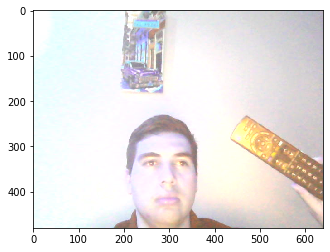

In [2]:
#Programa o codigo que captura la imagen de la camara
device = 0
cam = cv2.VideoCapture(0)
count = 1

# Se hace de forma iterativa hasta que se acaben los frames
while cam.isOpened() and count > 0:
    # Capture frame-by-frame
    ret, frame = cam.read()
    if ret == False:
        print("End of video")
        break;
 
    plt.imshow(frame)
    plt.show()
    count -= 1
 
cam.release()

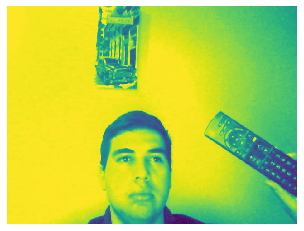

In [3]:
# Pasar la imagen a un espacio de color gris
image = frame
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(gray)
plt.show()


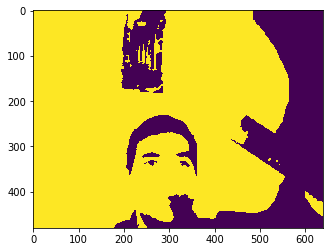

In [4]:
# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
#image = cv2.imread(args["image"])
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
#cv2.imshow("Input", image)
 
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)
plt.show()

In [ ]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
 
    # Dibujar un circulo para encerrar los objetos
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

[INFO] 6 unique segments found
